In [124]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
from lwa_f import blocks
#from lwautils import lwa_arx 
import pandas as pd
#from cr_functions import *
from cr_data_inspection_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st
from lwa_antpos import mapping
import os

In [158]:
datadir='/home/ubuntu/kp/data/2023Jan14'
files=os.listdir(datadir)
snap02datafiles=[s for s in files if (s[:6]=='snap02' and s[6]!='t')]
snap03datafiles=[s for s in files if (s[:6]=='snap03' and s[6]!='t')]
snap04datafiles=[s for s in files if (s[:6]=='snap04' and s[6]!='t')]
snap05datafiles=[s for s in files if (s[:6]=='snap05' and s[6]!='t')]
snap06datafiles=[s for s in files if (s[:6]=='snap06' and s[6]!='t')]
snap07datafiles=[s for s in files if (s[:6]=='snap07' and s[6]!='t')]
snap08datafiles=[s for s in files if (s[:6]=='snap08' and s[6]!='t')]
snap09datafiles=[s for s in files if (s[:6]=='snap09' and s[6]!='t')]
snap10datafiles=[s for s in files if (s[:6]=='snap10' and s[6]!='t')]
snap11datafiles=[s for s in files if (s[:6]=='snap11' and s[6]!='t')]


In [224]:
def prob_simple(x,s):
    #fraction of samples whose absolute value iexceeds a threshold x if the sample is described by a Gaussian PDF with zero mean and variance s^2
    p = 1 - 0.5*(sp.erf((x)/((2**0.5)*s)) + sp.erf((x)/((2**0.5)*s)))
    return p

def consolidate_threshold_scan_data(boardname,datadir):
    allfiles=os.listdir(datadir)
    sortedfiles=allfiles.sort
    datafiles=[s for s in allfiles if (s[:6]==boardname and s[6]!='t')]
    alldata=np.zeros((64,int(len(datafiles)/2),len(thresholds),2))
    timestamps=[]
    results_dictionary={}
    boardnumber=int(boardname[5:])
    
    #organize the data from each file into the array alldata
    t=0
    for i,f in enumerate(datafiles):
        filename=datafiles[i]
        if filename[-5]=='c':
            timestamps.append(float(f[6:-13]))
            data_c=np.load(datadir+f)
            data_v=np.load(datadir+f[:-5]+'v'+f[-4:])
            alldata[:,t,:,0]=data_c
            alldata[:,t,:,1]=data_v
            t+=1
        elif filename[-5]=='v':
            pass
        else:
            print('Could not parse file name ',filename)

    
    #rearrange into dictionary based on antenna name
    for a in range(64):
        antname=mapping.snap2_to_antpol(boardnumber,a)
        results_dictionary[antname]=alldata[a]
    return results_dictionary,timestamps

In [225]:
datadir='/home/ubuntu/kp/data/2023Jan14/'
#datadir='/home/ubuntu/kp/data/smalltest/'

results_dictionary,timestamps=consolidate_threshold_scan_data('snap02',datadir)
print(results_dictionary.keys())
print(len(timestamps))

dict_keys(['LWA-257A', 'LWA-257B', 'LWA-255A', 'LWA-255B', 'LWA-260A', 'LWA-260B', 'LWA-258A', 'LWA-258B', 'LWA-265A', 'LWA-265B', 'LWA-263A', 'LWA-263B', 'LWA-272A', 'LWA-272B', 'LWA-270A', 'LWA-270B', 'LWA-283A', 'LWA-283B', 'LWA-280A', 'LWA-280B', 'LWA-288A', 'LWA-288B', 'LWA-284A', 'LWA-284B', 'LWA-292A', 'LWA-292B', 'LWA-291A', 'LWA-291B', 'LWA-296A', 'LWA-296B', 'LWA-295A', 'LWA-295B', 'LWA-301A', 'LWA-301B', 'LWA-298A', 'LWA-298B', 'LWA-305A', 'LWA-305B', 'LWA-303A', 'LWA-303B', 'LWA-317A', 'LWA-317B', 'LWA-306A', 'LWA-306B', 'LWA-320A', 'LWA-320B', 'LWA-318A', 'LWA-318B', 'LWA-336A', 'LWA-336B', 'LWA-335A', 'LWA-335B', 'LWA-343A', 'LWA-343B', 'LWA-337A', 'LWA-337B', 'LWA-351A', 'LWA-351B', 'LWA-344A', 'LWA-344B', 'LWA-360A', 'LWA-360B', 'LWA-354A', 'LWA-354B'])
54


Fit Core
[47.03587788]
[[0.00177199]]
Fit Veto
[46.83879772]
[[0.00149923]]


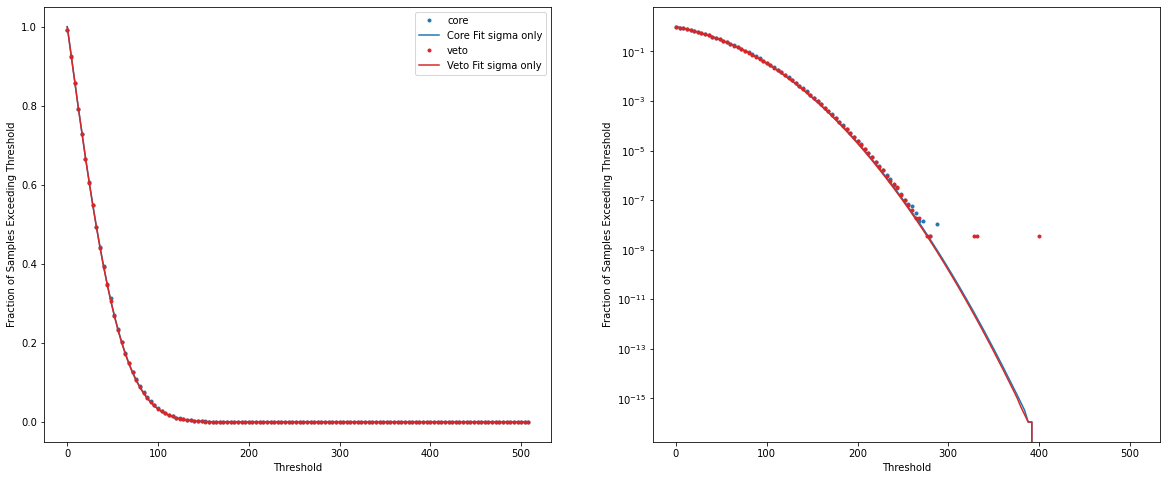

In [226]:
#compare to old plotting approach
thresholds = 4*np.asarray(range(128))
vthresholds = np.flip(thresholds)

boardnumber=2
time=3

results_core=results_dictionary['LWA-255B'][time,:,0]  #first test core
results_veto=results_dictionary['LWA-255B'][time,:,1]  #first test veto

rate_core = results_core/(2**28 - 1)
rate_veto = results_veto/(2**28 - 1)

corefitsigmas = np.zeros(64)
corefitsigmaerrs = np.zeros(64)
vetofitsigmas = np.zeros(64)
vetofitsigmaerrs = np.zeros(64)


print("Fit Core")
popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[:])
corefitsigmas[a]=popt1[0]
corefitsigmaerrs[a]=pcov1[0]
print(popt1)
print(pcov1)
print("Fit Veto")
popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[:]))
vetofitsigmas[a]=popt2[0]
vetofitsigmaerrs[a]=pcov2[0]
print(popt2)
print(pcov2)
model1 = prob_simple(thresholds,popt1[0])
model2 = prob_simple(thresholds,popt2[0])

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.plot(thresholds,rate_core[:],'C0.',label='core')
plt.plot(thresholds,model1,'C0-',label="Core Fit sigma only")
plt.plot(np.flip(thresholds),rate_veto[:],'C3.',label='veto')
plt.plot(thresholds,model2,'C3-',label="Veto Fit sigma only")
plt.legend()

plt.subplot(122)
plt.xlabel("Threshold")
plt.ylabel("Fraction of Samples Exceeding Threshold")
plt.semilogy(thresholds,rate_core[:],'C0.',label='core')
plt.semilogy(thresholds,model1,'C0-',label="Core Fit sigma only")
plt.semilogy(np.flip(thresholds),rate_veto[:],'C3.',label='veto')
plt.semilogy(thresholds,model2,'C3-',label="Veto Fit sigma only")
plt.show()

In [227]:
print(timestamps[0])

1673812946.4934263


In [228]:
'''#compare to old plotting approach
thresholds = 4*np.asarray(range(128))
vthresholds = np.flip(thresholds)

boardnumber=2
for time in range(len(timestamps)):
    results_core=np.load(datadir+'snap02'+str(timestamps[time])+'results_c.npy')
    results_veto=np.load(datadir+'snap02'+str(timestamps[time])+'results_v.npy')
    rate_core = results_core/(2**28 - 1)
    rate_veto = results_veto/(2**28 - 1)

    corefitsigmas = np.zeros(64)
    corefitsigmaerrs = np.zeros(64)
    vetofitsigmas = np.zeros(64)
    vetofitsigmaerrs = np.zeros(64)

    #for a in range(64):
    for a in [3]: #concentrate on one antenna for now
        antname=mapping.snap2_to_antpol(boardnumber,a)
        print(antname)
        print("Fit Core")
        popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[a,:])
        corefitsigmas[a]=popt1[0]
        corefitsigmaerrs[a]=pcov1[0]
        print(popt1)
        print(pcov1)

        print("Fit Veto")
        popt2,pcov2 = oz.curve_fit(prob_simple,thresholds,np.flip(rate_veto[a,:]))
        vetofitsigmas[a]=popt2[0]
        vetofitsigmaerrs[a]=pcov2[0]
        print(popt2)
        print(pcov2)

        model1 = prob_simple(thresholds,popt1[0])
        model2 = prob_simple(thresholds,popt2[0])

        plt.figure(figsize=(20,8))
        plt.subplot(121)
        plt.xlabel("Threshold")
        plt.ylabel("Fraction of Samples Exceeding Threshold")
        plt.plot(thresholds,rate_core[a,:],'C0.',label='core')
        plt.plot(thresholds,model1,'C0-',label="Core Fit sigma only")

        plt.plot(np.flip(thresholds),rate_veto[a,:],'C3.',label='veto')
        plt.plot(thresholds,model2,'C3-',label="Veto Fit sigma only")

        plt.legend()

        plt.subplot(122)
        plt.xlabel("Threshold")
        plt.ylabel("Fraction of Samples Exceeding Threshold")
        plt.semilogy(thresholds,rate_core[a,:],'C0.',label='core')
        plt.semilogy(thresholds,model1,'C0-',label="Core Fit sigma only")

        plt.semilogy(np.flip(thresholds),rate_veto[a,:],'C3.',label='veto')
        plt.semilogy(thresholds,model2,'C3-',label="Veto Fit sigma only")
        plt.show()'''

'#compare to old plotting approach\nthresholds = 4*np.asarray(range(128))\nvthresholds = np.flip(thresholds)\n\nboardnumber=2\nfor time in range(len(timestamps)):\n    results_core=np.load(datadir+\'snap02\'+str(timestamps[time])+\'results_c.npy\')\n    results_veto=np.load(datadir+\'snap02\'+str(timestamps[time])+\'results_v.npy\')\n    rate_core = results_core/(2**28 - 1)\n    rate_veto = results_veto/(2**28 - 1)\n\n    corefitsigmas = np.zeros(64)\n    corefitsigmaerrs = np.zeros(64)\n    vetofitsigmas = np.zeros(64)\n    vetofitsigmaerrs = np.zeros(64)\n\n    #for a in range(64):\n    for a in [3]: #concentrate on one antenna for now\n        antname=mapping.snap2_to_antpol(boardnumber,a)\n        print(antname)\n        print("Fit Core")\n        popt1,pcov1 = oz.curve_fit(prob_simple,thresholds,rate_core[a,:])\n        corefitsigmas[a]=popt1[0]\n        corefitsigmaerrs[a]=pcov1[0]\n        print(popt1)\n        print(pcov1)\n\n        print("Fit Veto")\n        popt2,pcov2 = oz.

In [229]:
lwa255B=results_dictionary['LWA-255B']

0.0


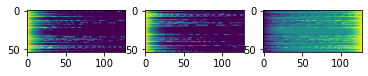

In [230]:
plt.figure()
plt.subplot(131)
plt.imshow(lwa255B[:,:,0])
plt.subplot(132)
plt.imshow(np.flip(lwa255B[:,:,1]))
plt.subplot(133)
plt.imshow(lwa255B[:,:,1]-np.flip(lwa255B[:,:,1]))
print(np.min(lwa255B[:,:,1]-lwa255B[:,:,1]))

Text(0, 0.5, 'threshold [ADC units]')

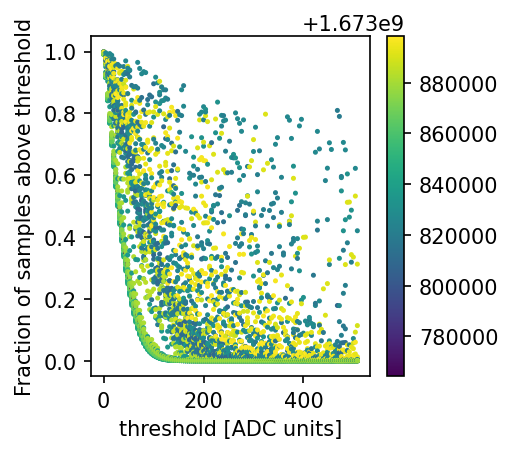

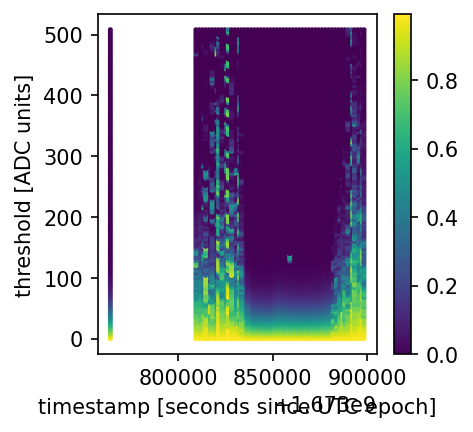

In [270]:
plt.figure(figsize=(3,3),dpi=150)
#plt.subplot(121)
for th in range(len(thresholds)):
    plt.scatter(thresholds[th]*np.ones(len(timestamps)),lwa255B[:,th,0]/(2**28 - 1),c=timestamps,s=2)
plt.colorbar()
plt.xlabel('threshold [ADC units]')
plt.ylabel('Fraction of samples above threshold')
#plt.colorlabel('timestamp [seconds since UTC epoch]')

plt.figure(figsize=(3,3),dpi=150)
#plt.subplot(122)
for t in range(len(timestamps)):
    plt.scatter(timestamps[t]*np.ones(len(thresholds)),thresholds,c=lwa255B[t,:,0]/(2**28 - 1),s=2)
plt.colorbar()  
plt.xlabel('timestamp [seconds since UTC epoch]')
plt.ylabel('threshold [ADC units]')
#plt.colorlabel('fraction of samples above threshold')




In [309]:
results_dictionary2,timestamps2=consolidate_threshold_scan_data('snap02',datadir)
results_dictionary3,timestamps3=consolidate_threshold_scan_data('snap03',datadir)
results_dictionary4,timestamps4=consolidate_threshold_scan_data('snap04',datadir)
results_dictionary5,timestamps5=consolidate_threshold_scan_data('snap05',datadir)
results_dictionary6,timestamps6=consolidate_threshold_scan_data('snap06',datadir)
results_dictionary7,timestamps7=consolidate_threshold_scan_data('snap07',datadir)
results_dictionary8,timestamps8=consolidate_threshold_scan_data('snap08',datadir)
results_dictionary9,timestamps9=consolidate_threshold_scan_data('snap09',datadir)
#results_dictionary10,timestamps=consolidate_threshold_scan_data('snap10',datadir)  ## Why doesn't 10 work??
results_dictionary11,timestamps11=consolidate_threshold_scan_data('snap11',datadir)

print(results_dictionary5.keys())

dict_keys(['LWA-030A', 'LWA-030B', 'LWA-028A', 'LWA-028B', 'LWA-032A', 'LWA-032B', 'LWA-031A', 'LWA-031B', 'LWA-063A', 'LWA-063B', 'LWA-060A', 'LWA-060B', 'LWA-057A', 'LWA-057B', 'LWA-056A', 'LWA-056B', 'LWA-059A', 'LWA-059B', 'LWA-058A', 'LWA-058B', 'LWA-062A', 'LWA-062B', 'LWA-061A', 'LWA-061B', 'LWA-085A', 'LWA-085B', 'LWA-064A', 'LWA-064B', 'LWA-087A', 'LWA-087B', 'LWA-086A', 'LWA-086B', 'LWA-089A', 'LWA-089B', 'LWA-096A', 'LWA-096B', 'LWA-091A', 'LWA-091B', 'LWA-090A', 'LWA-090B', 'LWA-093A', 'LWA-093B', 'LWA-092A', 'LWA-092B', 'LWA-095A', 'LWA-095B', 'LWA-094A', 'LWA-094B', 'LWA-122A', 'LWA-122B', 'LWA-121A', 'LWA-121B', 'LWA-325A', 'LWA-325B', 'LWA-316A', 'LWA-316B', 'LWA-334A', 'LWA-334B', 'LWA-328A', 'LWA-328B', 'LWA-361A', 'LWA-361B', 'LWA-358A', 'LWA-358B'])


dict_keys(['LWA-030A', 'LWA-030B', 'LWA-028A', 'LWA-028B', 'LWA-032A', 'LWA-032B', 'LWA-031A', 'LWA-031B', 'LWA-063A', 'LWA-063B', 'LWA-060A', 'LWA-060B', 'LWA-057A', 'LWA-057B', 'LWA-056A', 'LWA-056B', 'LWA-059A', 'LWA-059B', 'LWA-058A', 'LWA-058B', 'LWA-062A', 'LWA-062B', 'LWA-061A', 'LWA-061B', 'LWA-085A', 'LWA-085B', 'LWA-064A', 'LWA-064B', 'LWA-087A', 'LWA-087B', 'LWA-086A', 'LWA-086B', 'LWA-089A', 'LWA-089B', 'LWA-096A', 'LWA-096B', 'LWA-091A', 'LWA-091B', 'LWA-090A', 'LWA-090B', 'LWA-093A', 'LWA-093B', 'LWA-092A', 'LWA-092B', 'LWA-095A', 'LWA-095B', 'LWA-094A', 'LWA-094B', 'LWA-122A', 'LWA-122B', 'LWA-121A', 'LWA-121B', 'LWA-325A', 'LWA-325B', 'LWA-316A', 'LWA-316B', 'LWA-334A', 'LWA-334B', 'LWA-328A', 'LWA-328B', 'LWA-361A', 'LWA-361B', 'LWA-358A', 'LWA-358B'])


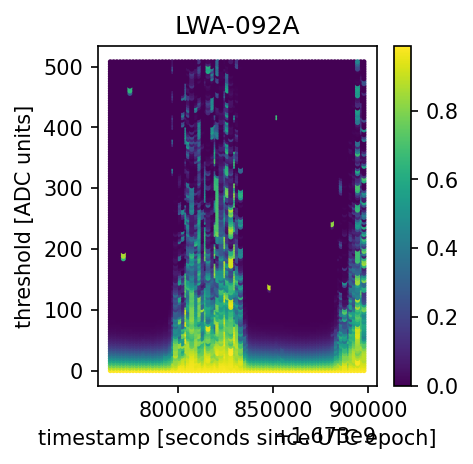

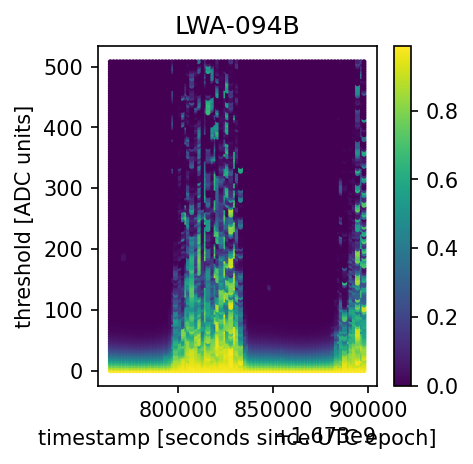

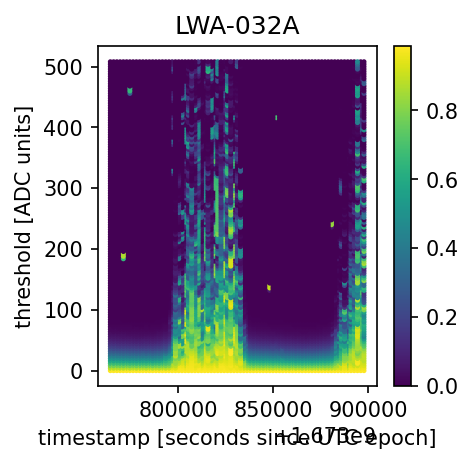

In [287]:
print(results_dictionary5.keys())
antennas=['LWA-092A','LWA-094B','LWA-032A']
for a in antennas:
    antennadata=results_dictionary5[a]
    plt.figure(figsize=(3,3),dpi=150)
    plt.title(a)
    for t in range(len(timestamps5)):
        plt.scatter(timestamps5[t]*np.ones(len(thresholds)),thresholds,c=antennadata[t,:,0]/(2**28 - 1),s=2)
    plt.colorbar()  
    plt.xlabel('timestamp [seconds since UTC epoch]')
    plt.ylabel('threshold [ADC units]')
    #plt.colorlabel('fraction of samples above threshold')

dict_keys(['LWA-078A', 'LWA-078B', 'LWA-076A', 'LWA-076B', 'LWA-081A', 'LWA-081B', 'LWA-079A', 'LWA-079B', 'LWA-108A', 'LWA-108B', 'LWA-107A', 'LWA-107B', 'LWA-110A', 'LWA-110B', 'LWA-109A', 'LWA-109B', 'LWA-112A', 'LWA-112B', 'LWA-111A', 'LWA-111B', 'LWA-114A', 'LWA-114B', 'LWA-113A', 'LWA-113B', 'LWA-116A', 'LWA-116B', 'LWA-115A', 'LWA-115B', 'LWA-118A', 'LWA-118B', 'LWA-117A', 'LWA-117B', 'LWA-120A', 'LWA-120B', 'LWA-082A', 'LWA-082B', 'LWA-143A', 'LWA-143B', 'LWA-142A', 'LWA-142B', 'LWA-145A', 'LWA-145B', 'LWA-144A', 'LWA-144B', 'LWA-147A', 'LWA-147B', 'LWA-150A', 'LWA-150B', 'LWA-149A', 'LWA-149B', 'LWA-148A', 'LWA-148B', 'LWA-151A', 'LWA-151B', 'LWA-172A', 'LWA-172B', 'LWA-279A', 'LWA-279B', 'LWA-178A', 'LWA-178B', 'LWA-355A', 'LWA-355B', 'LWA-287A', 'LWA-287B'])


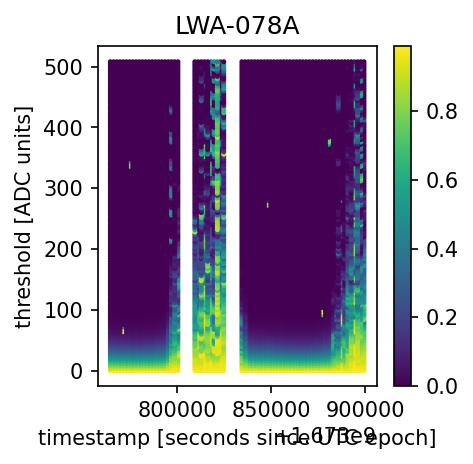

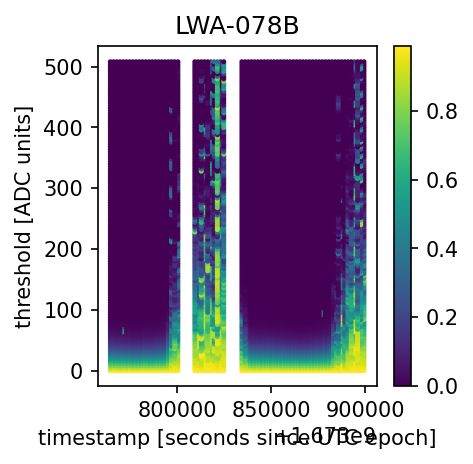

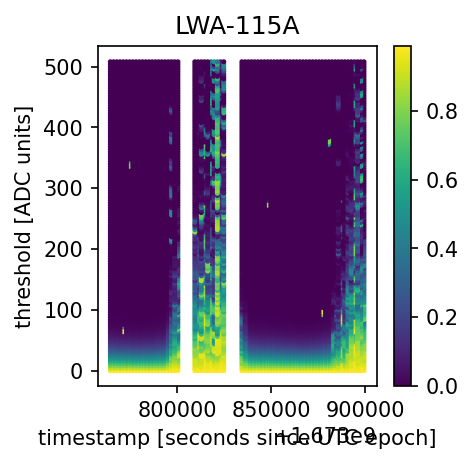

In [288]:
print(results_dictionary7.keys())
antennas=['LWA-078A','LWA-078B','LWA-115A']
for a in antennas:
    antennadata=results_dictionary7[a]
    plt.figure(figsize=(3,3),dpi=150)
    plt.title(a)
    for t in range(len(timestamps7)):
        plt.scatter(timestamps7[t]*np.ones(len(thresholds)),thresholds,c=antennadata[t,:,0]/(2**28 - 1),s=2)
    plt.colorbar()  
    plt.xlabel('timestamp [seconds since UTC epoch]')
    plt.ylabel('threshold [ADC units]')
    #plt.colorlabel('fraction of samples above threshold')

## How often does it saturate?

dict_keys(['LWA-078A', 'LWA-078B', 'LWA-076A', 'LWA-076B', 'LWA-081A', 'LWA-081B', 'LWA-079A', 'LWA-079B', 'LWA-108A', 'LWA-108B', 'LWA-107A', 'LWA-107B', 'LWA-110A', 'LWA-110B', 'LWA-109A', 'LWA-109B', 'LWA-112A', 'LWA-112B', 'LWA-111A', 'LWA-111B', 'LWA-114A', 'LWA-114B', 'LWA-113A', 'LWA-113B', 'LWA-116A', 'LWA-116B', 'LWA-115A', 'LWA-115B', 'LWA-118A', 'LWA-118B', 'LWA-117A', 'LWA-117B', 'LWA-120A', 'LWA-120B', 'LWA-082A', 'LWA-082B', 'LWA-143A', 'LWA-143B', 'LWA-142A', 'LWA-142B', 'LWA-145A', 'LWA-145B', 'LWA-144A', 'LWA-144B', 'LWA-147A', 'LWA-147B', 'LWA-150A', 'LWA-150B', 'LWA-149A', 'LWA-149B', 'LWA-148A', 'LWA-148B', 'LWA-151A', 'LWA-151B', 'LWA-172A', 'LWA-172B', 'LWA-279A', 'LWA-279B', 'LWA-178A', 'LWA-178B', 'LWA-355A', 'LWA-355B', 'LWA-287A', 'LWA-287B'])
dict_keys(['LWA-030A', 'LWA-030B', 'LWA-028A', 'LWA-028B', 'LWA-032A', 'LWA-032B', 'LWA-031A', 'LWA-031B', 'LWA-063A', 'LWA-063B', 'LWA-060A', 'LWA-060B', 'LWA-057A', 'LWA-057B', 'LWA-056A', 'LWA-056B', 'LWA-059A', 'LWA-

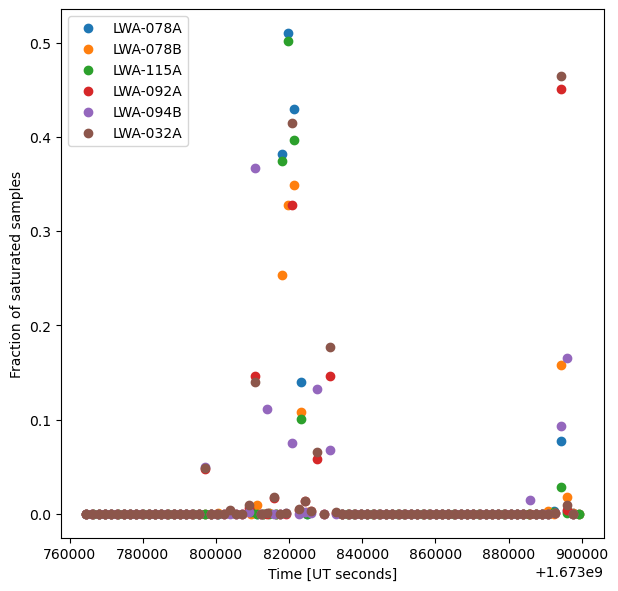

In [306]:
plt.figure(figsize=(7,7),dpi=100)
print(results_dictionary7.keys())
antennas=['LWA-078A','LWA-078B','LWA-115A']
for a in antennas:
    antennadata=results_dictionary7[a]
    plt.plot(timestamps7,antennadata[:,-1,0]/(2**28 - 1),'o',label=a)


print(results_dictionary5.keys())
antennas=['LWA-092A','LWA-094B','LWA-032A']
for a in antennas:
    antennadata=results_dictionary5[a]
    plt.plot(timestamps5,antennadata[:,-1,0]/(2**28 - 1),'o',label=a)

plt.xlabel("Time [UT seconds]")
plt.ylabel("Fraction of saturated samples")
plt.legend()

Text(0, 0.5, 'Fraction of saturated samples')

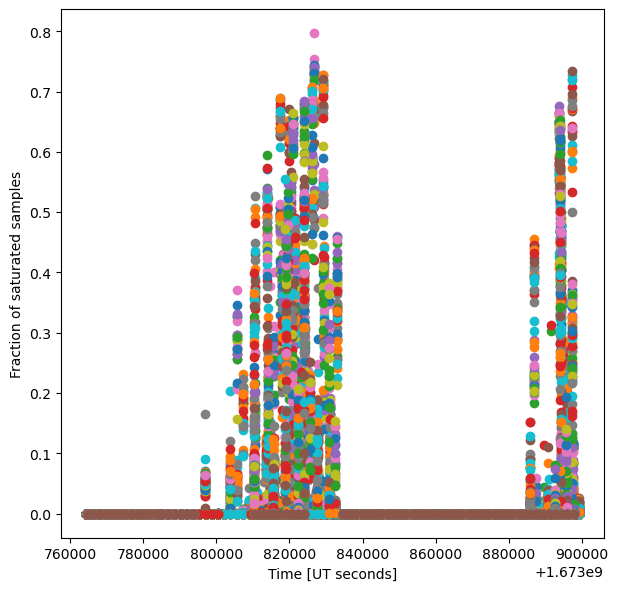

In [311]:
peaksaturation=[] #array holding the worst fraction of saturated samples for each antenna
plt.figure(figsize=(7,7),dpi=100)
results_dictionaries=[results_dictionary2,
                      results_dictionary3,
                      results_dictionary4,
                      results_dictionary5,
                      results_dictionary6,
                      results_dictionary7,
                      results_dictionary8,
                      results_dictionary9,
                      results_dictionary11]
timestamparrays=[timestamps2,
                timestamps3,
                timestamps4,
                timestamps5,
                timestamps6,
                timestamps7,
                timestamps8,
                timestamps9,
                timestamps11]
for i in range(len(timestamparrays)):
    timestamps=timestamparrays[i]
    results_dictionary=results_dictionaries[i]
    antennas=results_dictionary.keys()
    for a in antennas:
        antennadata=results_dictionary[a]
        plt.plot(timestamps,antennadata[:,-1,0]/(2**28 - 1),'o')
        peaksaturation.append(np.max(antennadata[:,-1,0]/(2**28 - 1)))

plt.xlabel("Time [UT seconds]")
plt.ylabel("Fraction of saturated samples")

Text(0, 0.5, 'Number of antennas')

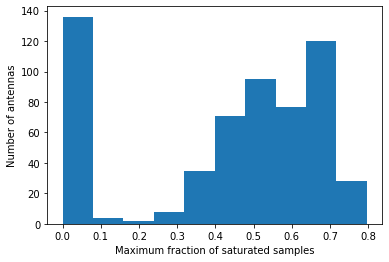

In [313]:
plt.hist(peaksaturation)
plt.xlabel("Maximum fraction of saturated samples")
plt.ylabel("Number of antennas")